In [1]:
import matplotlib.pyplot as pt
import numpy as np
import torch as tr
import random
import requests
import math
import torch.nn.functional as F

In [2]:
"""
Download metamath set.mm into colab runtime
"""
!wget https://github.com/metamath/set.mm/raw/develop/set.mm

--2023-05-06 18:43:40--  https://github.com/metamath/set.mm/raw/develop/set.mm
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/metamath/set.mm/develop/set.mm [following]
--2023-05-06 18:43:40--  https://raw.githubusercontent.com/metamath/set.mm/develop/set.mm
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43107725 (41M) [text/plain]
Saving to: ‘set.mm.2’

set.mm.2            100%[===================>]  41.11M   191MB/s    in 0.2s    

2023-05-06 18:43:41 (191 MB/s) - ‘set.mm.2’ saved [43107725/43107725]



In [3]:
"""
Load database into memory
thms[label] = (assertion, essential hypotheses, proof inferences) 
"""
def load_database(max_thms = None):

    with open("set.mm", "r") as f: raw = f.read()

    # collect theorems
    #This line of code initializes an empty dictionary called thms. 
    #This dictionary will be used to store the theorems parsed from the "set.mm" file. 
    thms = {}

    # parse
    #This line of code initializes a string variable tags containing the characters "cfeap=". 
    tags = "cfeap="
    #
    mark = {} #
    scope = [[]]
    comment = False
    last = ""
    for i in range(2, len(raw)):

        # comments
        if raw[i-2:i] == "$(": comment = True
        if raw[i-2:i] == "$)": comment = False
        if comment: continue

        # scope
        if raw[i-2:i] == "${": scope.append([])
        if raw[i-2:i] == "$}": scope.pop()

        # mark simple tags
        for t in tags:
            if raw[i-2:i] == "$"+t:
                last = t
                mark[t] = i

        # extract
        if raw[i-2:i] == "$.":
            # essential
            if last == 'e':
                hypot = raw[mark['e']+1:i-2]
                label = raw[raw[:mark['e']].rindex('\n'):mark['e']-2].strip()
                scope[-1].append((label, hypot))
            # axiom
            if last == 'a':
                assrt = raw[mark['a']+1:i-2]
                label = raw[raw[:mark['a']].rindex('\n'):mark['a']-2].strip()
                essen = tuple(e for s in scope for e in s)
                thms[label] = (assrt, essen, ())
            # theorem
            if last == '=':
                # proof = tuple(raw[mark['=']+1:i-3].split()) # uncompressed
                proof = raw[mark['=']+1:i-3]
                proof = tuple(proof[proof.find("(")+2:proof.find(")")-1].split())
                assrt = raw[mark['p']+1:mark['=']-2]
                label = raw[raw[:mark['p']].rindex('\n'):mark['p']-2].strip()
                essen = tuple(e for s in scope for e in s)
                thms[label] = (assrt, essen, proof)

            if last in 'a=' and len(thms) % 1000 == 0:
                print(f"{len(thms)} thms parsed...")
            if len(thms) == max_thms: break

    return thms

In [4]:
def tokenize(assrt, essen):
    tokens = assrt.split()
    for (label, hypot) in essen:
        tokens.extend(hypot.split())
    return tokens

def get_samples(thms):
    for label, (assrt, essen, proof) in thms.items():

        # skip axioms, they do not have proofs
        if len(proof) == 0: continue

        # lookup assertion of last proof step
        proof_assrt, proof_essen, _ = thms[proof[-1]]

        # tokenize input/output
        prompt = tokenize(assrt, essen)
        output = tokenize(proof_assrt, proof_essen)

        yield prompt, output

In [5]:
"""
Load big chunk of the database
"""
thms = load_database(22000)

1000 thms parsed...
2000 thms parsed...
2000 thms parsed...
3000 thms parsed...
4000 thms parsed...
5000 thms parsed...
5000 thms parsed...
5000 thms parsed...
5000 thms parsed...
6000 thms parsed...
6000 thms parsed...
7000 thms parsed...
7000 thms parsed...
7000 thms parsed...
8000 thms parsed...
9000 thms parsed...
10000 thms parsed...
11000 thms parsed...
12000 thms parsed...
13000 thms parsed...
14000 thms parsed...
15000 thms parsed...
15000 thms parsed...
15000 thms parsed...
15000 thms parsed...
15000 thms parsed...
15000 thms parsed...
15000 thms parsed...
15000 thms parsed...
16000 thms parsed...
16000 thms parsed...
16000 thms parsed...
16000 thms parsed...
17000 thms parsed...
18000 thms parsed...
19000 thms parsed...
20000 thms parsed...
20000 thms parsed...
20000 thms parsed...
20000 thms parsed...
21000 thms parsed...
21000 thms parsed...
21000 thms parsed...
21000 thms parsed...
22000 thms parsed...


In [6]:
"""
data stats: max sequence length and vocab size
"""
vocab = {"$=": 0, # reuse this token as a delimiter between goals (input) and proof steps (output)
         "$.": 0} # and this as end-of-sequence symbol 
seqlens = {}
for s, (prompt, output) in enumerate(get_samples(thms)):
    
    # full sequence length
    seq = prompt + ["$="] + output + ["$."]

    # update vocabulary
    for tok in seq: vocab[tok] = vocab.get(tok, 0) + 1

    # update length distribution
    seqlens[len(seq)] = seqlens.get(len(seq), 0) + 1

    if s % 5000 == 0: print(f"{s} of {len(thms)}, |V| >= {len(vocab)}, L >= {max(seqlens.keys())}")

0 of 22000, |V| >= 9, L >= 28
5000 of 22000, |V| >= 110, L >= 182
10000 of 22000, |V| >= 293, L >= 546
15000 of 22000, |V| >= 373, L >= 546
20000 of 22000, |V| >= 642, L >= 1140


In [7]:

"""
built-in pytorch embedding module refers to tokens by index in vocabulary
this wrapper looks up by token string
"""

class Embedder(tr.nn.Module):
    def __init__(self, vocab, d_model, device):
        super(Embedder, self).__init__()

        # lookup table mapping tokens to indices
        self.vocab = tuple(sorted(vocab.keys()))
        self.lookup = {tok: t for t, tok in enumerate(self.vocab)}

        # torch embedding module
        self.embedding = tr.nn.Embedding(len(vocab), d_model, device=device)

        # remember device for transfering input
        self.device = device

    def get_index(self, tokens):
        if type(tokens[0]) == list: # batch mode
            # tokens[n][t]: token at position t in example n of batch
            index = [[self.lookup[tok] for tok in toks] for toks in tokens]
        else:
            # tokens[t]: token at position t of tokens
            index = [self.lookup[tok] for tok in tokens]
        return tr.tensor(index, device=self.device)

    def get_tokens(self, index):
        if len(index.shape) > 1: # batch mode
            return [[self.vocab[i] for i in idx] for idx in index]
        else:
            return [self.vocab[i] for i in index]

    def forward(self, tokens):
        # lookup the token indices
        idx = self.get_index(tokens)
        # retrieve the embeddings
        return self.embedding(idx)

In [8]:
def make_positional_encodings(max_len, d_model, denom_base):
    d2 = d_model // 2
    PE = tr.cat([
        trig(tr.arange(max_len).unsqueeze(1) / denom_base**(tr.arange(d2)/d2))
        for trig in (tr.sin, tr.cos)], dim=1)
    return PE

In [9]:
class RelativePositionalEncoder(tr.nn.Module):
    def __init__(self, max_len, d_model, device):
        super(RelativePositionalEncoder, self).__init__()
        self.device = device
        
        # Matrix for computing relative position embeddings
        self.relative_mtx = tr.zeros((2 * max_len - 1, d_model))
        div_term = tr.exp(tr.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        for pos in range(max_len):
            for i in range(d_model//2):
                sin_idx = 2 * i
                cos_idx = 2 * i + 1
                self.relative_mtx[pos, sin_idx] = math.sin(pos * div_term[sin_idx % len(div_term)])
                self.relative_mtx[pos, cos_idx] = math.cos(pos * div_term[cos_idx % len(div_term)])
                if pos > 0:
                    self.relative_mtx[max_len + pos - 1, sin_idx] = math.cos(pos * div_term[sin_idx % len(div_term)])
                    self.relative_mtx[max_len + pos - 1, cos_idx] = math.sin(pos * div_term[cos_idx % len(div_term)])
        
        self.relative_mtx.requires_grad = False

    def forward(self, inputs):
        seq_len = inputs.shape[1]
        pos_idxs = tr.arange(seq_len).unsqueeze(0).repeat(seq_len, 1)
        rel_idxs = pos_idxs.transpose(0, 1) - pos_idxs + (seq_len - 1)
        rel_encodings = self.relative_mtx[rel_idxs].to(self.device)
        
        # Add relative encodings to inputs
        inputs = inputs.unsqueeze(1)  # Add a new dimension at index 1
        
        inputs = inputs + rel_encodings  # Add relative encodings to each input sequence
        
        inputs = inputs.sum(1)  # Remove the added dimension at index 1
        
        return inputs

In [10]:
def relative_trigonometric_positional_encoder(max_len, d_model, denom_base, device):
    PE = make_positional_encodings(max_len, d_model, denom_base)
    PE = PE.to(device)
    relative_positional_encoder = RelativePositionalEncoder(max_len, d_model, device)
    def encoder(inputs):
        inputs = relative_positional_encoder(inputs) # Add relative positional encodings
        return inputs + PE[:inputs.shape[1]] # Add trigonometric positional encodings
    return encoder


In [11]:
class EncoderDecoderAttentionTransformerPlus(tr.nn.Module):
    def __init__(self, vocab, max_len, denom_base, d_model, nhead, nlayers, ff_dim, device, use_attention=True):
        super(EncoderDecoderAttentionTransformerPlus, self).__init__()

        self.use_attention = use_attention

        # Token embeddings
        self.src_embedder = Embedder(vocab, d_model, device)
        self.tgt_embedder = Embedder(vocab, d_model, device)

        # Layer normalization
        self.src_norm = tr.nn.LayerNorm(d_model)
        self.tgt_norm = tr.nn.LayerNorm(d_model)

        # Convolutional layers
        self.src_conv = tr.nn.Conv1d(d_model, d_model, kernel_size=3, padding=1)
        self.tgt_conv = tr.nn.Conv1d(d_model, d_model, kernel_size=3, padding=1)

        # Positional encoding
        self.src_pos_encoder = relative_trigonometric_positional_encoder(max_len, d_model, denom_base, device) # LearnablePositionalEncoder(max_len, d_model, device)
        self.tgt_pos_encoder = relative_trigonometric_positional_encoder(max_len, d_model, denom_base, device) # LearnablePositionalEncoder(max_len, d_model, device)

        # Encoder stack
        encoder_layer = tr.nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=ff_dim,batch_first=True)
        self.encoder = tr.nn.TransformerEncoder(encoder_layer, nlayers)
        
       
        # Attention layer
        if self.use_attention:
            self.attention = tr.nn.MultiheadAttention(d_model, nhead, batch_first=True)

        # Decoder stack
        decoder_layer = tr.nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward=ff_dim,batch_first=True)
        self.decoder = tr.nn.TransformerDecoder(decoder_layer, nlayers)

        # Attention masks
        self.src_attn_mask = tr.triu(tr.full((max_len, max_len), float('-inf'), device=device), diagonal=1)
        self.tgt_attn_mask = tr.triu(tr.full((max_len, max_len), float('-inf'), device=device), diagonal=1)

        # Logit readout
        self.readout = tr.nn.Linear(d_model, len(vocab))

    def forward(self, src_seq, src_pad, tgt_seq, tgt_pad):
    ##encoder part
      src_seq = self.src_embedder(src_seq)
      src_seq = self.src_conv(src_seq.permute(0, 2, 1)).permute(0, 2, 1)
      src_seq = self.src_norm(src_seq)
      
      src_mask = self.src_attn_mask[:src_seq.shape[1], :src_seq.shape[1]]

      src_seq = self.encoder(src_seq, mask=src_mask, src_key_padding_mask=src_pad)

    ### target
      tgt_seq = self.tgt_embedder(tgt_seq)
      
      tgt_seq = self.tgt_conv(tgt_seq.permute(0, 2, 1)).permute(0, 2, 1)

      tgt_seq = self.tgt_norm(tgt_seq)
    # Add optional attention layer between encoder and decoder
      if self.use_attention:
          tgt_seq, _ = self.attention(tgt_seq, src_seq, src_seq)
        
      tgt_mask = self.tgt_attn_mask[:tgt_seq.shape[1], :tgt_seq.shape[1]]
      tgt_mask_src = self.src_attn_mask[:src_seq.shape[1], :src_seq.shape[1]]
      tgt_seq = self.decoder(tgt_seq, memory=src_seq, tgt_mask=tgt_mask, memory_mask=tgt_mask_src, tgt_key_padding_mask=tgt_pad, memory_key_padding_mask=src_pad)
    

    ## read out:
      logits = self.readout(tgt_seq)

      return logits






In [12]:
"""
Train/val/test split
"""
examples = []
for ex, (prompt, output) in enumerate(get_samples(thms)):
    if ex == 22000: break
    examples.append((prompt, output))
test=examples[20000:22000]   
random.shuffle(examples)
train, val = examples[:19000], examples[19000:20000]


In [13]:
print(len(test))

770


In [14]:
"""
Batch helper
"""
def get_batches(examples, batch_size, max_len):
    batch = []
    for prompt, output in examples:

        # skip examples with seqlen longer than max
        if len(prompt + ["$="] + output) > max_len: continue

        batch.append((prompt, output))
        if len(batch) == batch_size:
            yield batch
            batch = []

    # leftover small batch at end
    if len(batch) > 0: yield batch

def process_batch(batch, device, max_len):

    inps, outs, pads, prfs = [], [], [], []
    max_batch_len = 0
    for (prompt, output) in batch:
        seq = prompt + ["$="] + output + ["$."]

        # track max length in batch (-1 because inp = seq[:-1])
        max_batch_len = max(len(seq)-1, max_batch_len)

        # mark proof steps
        prf = [(len(prompt) <= t < len(seq)-1) for t in range(max_len)]

        # pad with stop tokens
        seq += ["$."] * (max_len - (len(seq)-1))
        
        # form training sequence, output shifted by one position
        inp, out = seq[:-1], seq[1:]
        pad = [(s == "$.") for s in inp]

        # inps[n][t]: token at pos t in example n
        inps.append(inp)
        outs.append(out)
        pads.append(pad)
        prfs.append(prf)

    # wrap masks in tensors
    pads = tr.tensor(pads, device=device)
    prfs = tr.tensor(prfs, device=device)

    # save space by limiting sequence dimension
    inps = [inp[:max_batch_len] for inp in inps]
    outs = [out[:max_batch_len] for out in outs]
    pads = pads[:,:max_batch_len]
    prfs = prfs[:,:max_batch_len]

    return inps, outs, pads, prfs

In [15]:
"""
Training loop
"""

device = tr.device('cpu')
device = tr.device("cuda:0" if tr.cuda.is_available() else "cpu")

max_len = 128
d_model = 256
nhead = 16
nlayers = 10
ff_dim = 4096
denom_base = 500

# batch for GPU speedup
batch_size =10

# noam schedule
use_noam = True
base_lr = 0.0005
warmup = 500
# init model (includes embedding and positional encoding)
model = EncoderDecoderAttentionTransformerPlus(vocab, max_len, denom_base, d_model, nhead, nlayers, ff_dim, device).to(device)

opt = tr.optim.Adam(model.parameters(), lr=base_lr)

# vanilla cross-entropy
loss_fn = tr.nn.CrossEntropyLoss(label_smoothing=0.0)

num_epochs = 20
max_examples = 1000
losses, accs = [], []
test_accs = []
val_accs = []
total_updates = 0
for epoch in range(num_epochs):

    # turn on training mode
    model.train()

    # use random data order every epoch
    random.shuffle(train)

    # train on all the training data
    num_examples = 0
    for batch in get_batches(train, batch_size, max_len):
        if num_examples == max_examples: break
        num_examples += len(batch)

        # preprocess batch
        inps, outs, pads, prfs = process_batch(batch, device, max_len)

        # reset gradient in preparation for forward/backward passes
        opt.zero_grad()

        
        # send example through model
        logits =  model(inps, pads, outs, prfs) # prediction logits shifted by one
        targets = model.tgt_embedder.get_index(outs)

        probs = tr.softmax(logits, dim=2)
        top_probs, top_idx = tr.max(probs, dim=2)
        preds_prt = model.tgt_embedder.get_tokens(top_idx)

        # reshape for cross-entropy
        N, L, V = logits.shape # batch size, max len, vocab size
        logits = logits.reshape((N*L, V))
        targets = targets.reshape((N*L,)) # index of correct token

        # only keep proof positions for loss
        prfs = prfs.flatten()
        logits, targets = logits[prfs], targets[prfs]

        # grad descent on cross-entropy
        loss = loss_fn(logits, targets)
        loss.backward()
        opt.step()

        # Noam ramp-up
        if use_noam:
            upd = total_updates + 1
            lr = base_lr * min(upd ** (-0.5), upd * warmup ** (-1.5))
            for p in opt.param_groups: p['lr'] = lr

        # accuracy of one-step-ahead prediction
        preds = logits.detach().argmax(dim=1)
        acc = (preds == targets).to(float).mean()

        # log results
        losses.append(loss.item())
        accs.append(acc.item())
        
        if num_examples % (batch_size * (100 // batch_size)) == 0:

            for n in range(len(inps)):
              print("inps: ", n, " ".join(inps[n]))
              print("outs: ", n, " ".join(outs[n]))
              print("pred: ", n, " ".join(preds_prt[n]))

            print(f"{epoch}|{num_examples}: loss={losses[-1]}, acc={accs[-1]}")# [{time_elapsed}s]")
        
        total_updates += 1

    # turn on evaluation mode
    model.eval()


    # validation 
    val_acc = []
    for batch in get_batches(val, batch_size, max_len):

        # preprocess batch
        inps, outs, pads, prfs = process_batch(batch, device, max_len)

        # send example through model
        with tr.no_grad():
            logits =  model(inps, pads, outs, prfs) # predictions shifted by one
            targets = model.src_embedder.get_index(outs)
            
            # reshape for cross-entropy
            N, L, V = logits.shape # batch size, max len, vocab size
            logits = logits.reshape((N*L, V))
            targets = targets.reshape((N*L,)) # index of correct token

            # only keep proof positions for loss
            prfs = prfs.flatten()
            logits, targets = logits[prfs], targets[prfs]

            # accuracy of one-step-ahead prediction
            preds = logits.detach().argmax(dim=1)
            acc = (preds == targets).to(float).mean()

            val_acc.append(acc.item())

    val_accs.append(np.mean(val_acc))
    print(f"\n **** validation acc = {val_accs[-1]} ****\n")


    # test on all the testing data
    test_acc = []
    for batch in get_batches(test, batch_size, max_len):

        # preprocess batch
        inps, outs, pads, prfs = process_batch(batch, device, max_len)

        # send example through model
        with tr.no_grad():
            logits =  model(inps, pads, outs, prfs) # predictions shifted by one
            targets = model.tgt_embedder.get_index(outs)
            
            # reshape for cross-entropy
            N, L, V = logits.shape # batch size, max len, vocab size
            logits = logits.reshape((N*L, V))
            targets = targets.reshape((N*L,)) # index of correct token

            # only keep proof positions for loss
            prfs = prfs.flatten()
            logits, targets = logits[prfs], targets[prfs]

            # accuracy of one-step-ahead prediction
            preds = logits.detach().argmax(dim=1)
            acc = (preds == targets).to(float).mean()

            test_acc.append(acc.item())

    test_accs.append(np.mean(test_acc))
    print(f"\n **** test acc = {test_accs[-1]} ****\n")

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


inps:  0 |- ( ph -> -. ps ) |- ( ph -> ch ) |- ( ph -> ( ps -> -. ch ) ) $= |- ( ph -> ch ) |- ( ph -> ps ) |- ( ph -> ( ps -> ch ) ) $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $.
outs:  0 ( ph -> -. ps ) |- ( ph -> ch ) |- ( ph -> ( ps -> -. ch ) ) $= |- ( ph -> ch ) |- ( ph -> ps ) |- ( ph -> ( ps -> ch ) ) $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $.
pred:  0 |- |- |- |- |- |- |- |- |- |- |- |- |- |- |- ) |- |- ) |- |- |- |- |- |- |- |- |- |- |- |- |- |- ) |- |- |- |- |- |- |- |- ) |- |- |- |- |- |- |- |- |- |- |- |- |- |- |- |- ) |- |- |- ) |- |- |- ) |- |- |- |- |- |- |- |- |- |- |- |- |- |- |- |- |- |- |- |- |- |- |- ) |- |- |- |- |- |- |- |- |- |- |- |- |- |- |- |-
inps:  1 |- -. 1 e. ( ZZ>= ` 2 ) $= |- -.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:544: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._transformer_encoder_layer_fwd(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/activation.py:1144: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


Streaming output truncated to the last 5000 lines.
outs:  8 ( R e. Grp -> R ~=g R ) $= |- ( ph -> ch ) |- ( ph -> ps ) |- ( ps -> ch ) $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $.
pred:  8 |- |- |- |- |- |- |- |- |- |- |- |- |- ) ( |- |- ( |- ( ( ( ( ( ( ( ) ) ( ) ( ) ( ( ( ( ) ( ( ( ) ) ( ( ( ( ) ( ( ) ) ) ( ( ) ( ( ( ( ) ) ) ) ) ( ( ) ( ) ) ( ( ( ( ) ( ( ) ) ) ( ) ) ) ( ( ) ) ) ) ) ) ) ) ) ( ) ) ( ) ) ) ) ) ( ( ( ) ) ) ) ) ) ( )
inps:  9 |- ( R e. V -> R Se A ) $= |- ( ph -> ch ) |- ( ph -> ps ) |- ( ch <-> ps ) $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $.
outs: 

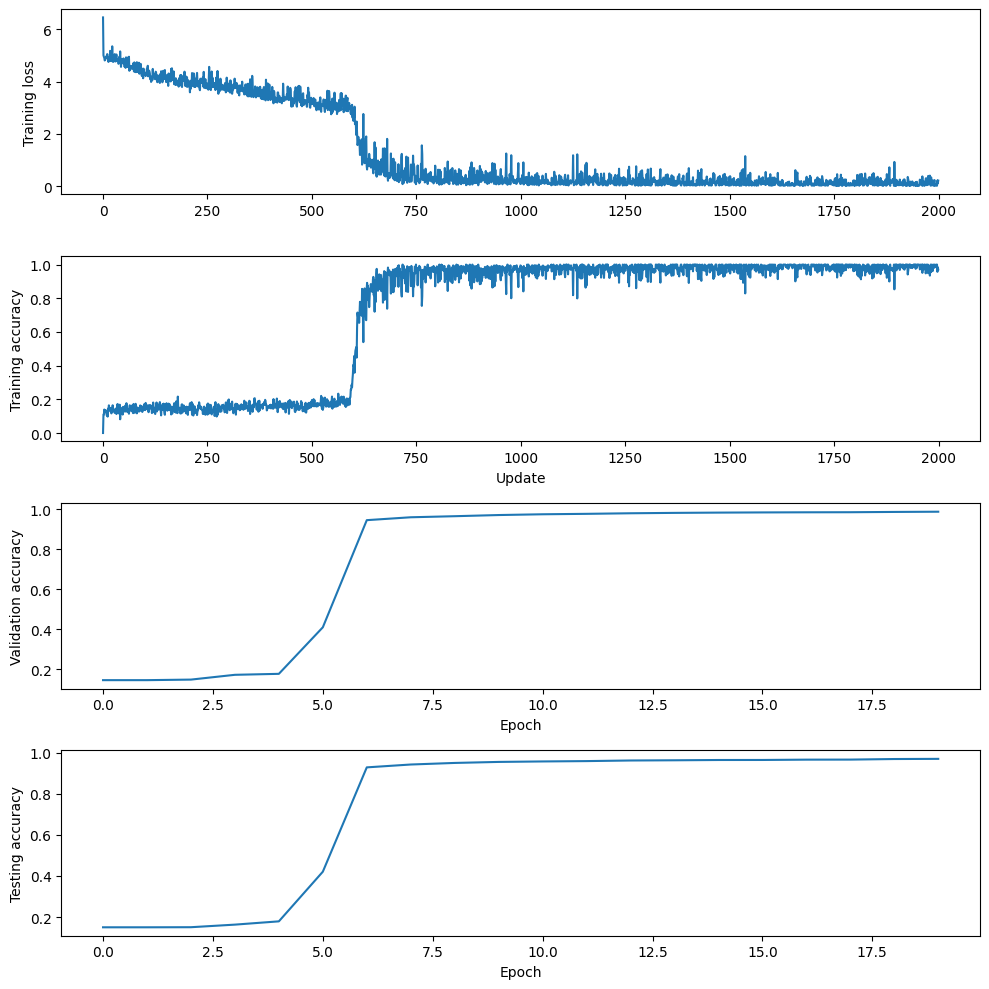

Average training accuracy: 71.89%
Average validation accuracy: 74.30%
Average testing accuracy: 73.12%


In [16]:
# exponential moving averages
ema_decay = 0.
metrics = {"loss": losses, "acc": accs, "val_acc": val_accs, "test_acc":test_accs}
emas = {}
for name, metric in metrics.items():
    emas[name] = [metric[0]]
    for i in range(1, len(metric)):
        emas[name].append(ema_decay*emas[name][-1] + (1 - ema_decay)*metric[i])

fig = pt.figure(figsize=(10,10)) 

pt.subplot(4,1,1)
pt.plot(emas['loss'])
pt.ylabel("Training loss")
pt.subplot(4,1,2)
pt.plot(emas['acc'])
pt.ylabel("Training accuracy")
pt.xlabel("Update")
pt.subplot(4,1,3)
pt.plot(val_accs, label="Unbalanced")
pt.ylabel("Validation accuracy")
pt.xlabel("Epoch")
pt.subplot(4,1,4)
pt.plot(test_accs, label="Unbalanced")
pt.ylabel("Testing accuracy")
pt.xlabel("Epoch")

pt.tight_layout()
pt.savefig("wxexp1.png")
pt.show()

average_acc = sum(emas['acc']) / len(emas['acc'])
print(f"Average training accuracy: {average_acc:.2%}")
average_val_acc = sum(emas['val_acc']) / len(emas['val_acc'])
print(f"Average validation accuracy: {average_val_acc:.2%}")
average_test_acc = sum(emas['test_acc']) / len(emas['test_acc'])
print(f"Average testing accuracy: {average_test_acc:.2%}")

In [17]:
"""
sanity-check high training accuracy
"""

# eval mode (no dropout noise)
model.eval()

for batch in get_batches(train, batch_size, max_len):

    # preprocess batch
    inps, outs, pads, prfs = process_batch(batch, device, max_len)

    # send example through model
    with tr.no_grad():
          logits =  model(inps, pads, outs, prfs) # predictions shifted by one
          targets = model.tgt_embedder.get_index(outs)

    probs = tr.softmax(logits, dim=2)
    top_probs, top_idx = tr.max(probs, dim=2)
    preds = model.tgt_embedder.get_tokens(top_idx)

    correct = []
    for n in range(len(inps)):
        
        print(n, " ".join(inps[n]))
        print("t, correct, prob of prediction vs target, prediction vs target")
        for t in range(len(inps[n])):
            if not prfs[n,t]: continue

            # accuracy of one-step-ahead prediction
            correct.append(preds[n][t] == outs[n][t])
            print(f"{t}: [p={top_probs[n,t]:3.3f} vs {probs[n,t,targets[n,t]]:3.3f}] {str(correct[-1])[0]}: {preds[n][t]} vs {outs[n][t]}")
        
        break
    break


0 |- 1 e. ( 0 [,] 1 ) $= |- ph |- ps |- ch |- th |- ( ph <-> ( ps /\ ch /\ th ) ) $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $.
t, correct, prob of prediction vs target, prediction vs target
8: [p=0.988 vs 0.988] T: |- vs |-
9: [p=0.988 vs 0.988] T: ph vs ph
10: [p=0.989 vs 0.989] T: |- vs |-
11: [p=0.984 vs 0.984] T: ps vs ps
12: [p=0.989 vs 0.989] T: |- vs |-
13: [p=0.981 vs 0.981] T: ch vs ch
14: [p=0.989 vs 0.989] T: |- vs |-
15: [p=0.969 vs 0.969] T: th vs th
16: [p=0.989 vs 0.989] T: |- vs |-
17: [p=0.987 vs 0.987] T: ( vs (
18: [p=0.988 vs 0.988] T: ph vs ph
19: [p=0.978 vs 0.978] T: <-> vs <->
20: [p=0.987 vs 0.987] T: ( vs (
21: [p=0.983 vs 0.983] T: ps vs ps
22: [p=0.974 vs 0.974] T: /\ vs /\
23: [p=0.981 vs 0.981] T: ch vs ch
24: [p=0.974 vs 0.974] T: /\ vs /\
25: [p=0.972 vs 0.972] T: th vs th
26: [p=0.990 vs 0.990] T: ) vs )
27: [p=0.990 vs 0.990] T: ) vs )
28: [p=0.984 

In [18]:
"""
Training loop
"""

device = tr.device('cpu')
device = tr.device("cuda:0" if tr.cuda.is_available() else "cpu")

max_len = 128
d_model = 256
nhead = 16
nlayers = 10
ff_dim = 4096
denom_base = 500

# batch for GPU speedup
batch_size =10

# noam schedule
use_noam = True
base_lr = 0.0005
warmup = 500
# init model (includes embedding and positional encoding)
model = EncoderDecoderAttentionTransformerPlus(vocab, max_len, denom_base, d_model, nhead, nlayers, ff_dim, device).to(device)

opt = tr.optim.Adam(model.parameters(), lr=base_lr)

# vanilla cross-entropy
loss_fn = tr.nn.CrossEntropyLoss(label_smoothing=0.0)

num_epochs = 20
max_examples = 1000
losses, accs = [], []
test_accs = []
val_accs = []
total_updates = 0
for epoch in range(num_epochs):

    # turn on training mode
    model.train()

    # use random data order every epoch
    random.shuffle(train)

    # train on all the training data
    num_examples = 0
    for batch in get_batches(train, batch_size, max_len):
        if num_examples == max_examples: break
        num_examples += len(batch)

        # preprocess batch
        inps, outs, pads, prfs = process_batch(batch, device, max_len)

        # reset gradient in preparation for forward/backward passes
        opt.zero_grad()

        
        # send example through model
        logits =  model(inps, pads, outs, prfs) # prediction logits shifted by one
        targets = model.tgt_embedder.get_index(outs)

        probs = tr.softmax(logits, dim=2)
        top_probs, top_idx = tr.max(probs, dim=2)
        preds_prt = model.tgt_embedder.get_tokens(top_idx)

        # reshape for cross-entropy
        N, L, V = logits.shape # batch size, max len, vocab size
        logits = logits.reshape((N*L, V))
        targets = targets.reshape((N*L,)) # index of correct token

        # only keep proof positions for loss
        prfs = prfs.flatten()
        logits, targets = logits[prfs], targets[prfs]

        # grad descent on cross-entropy
        loss = loss_fn(logits, targets)
        loss.backward()
        opt.step()

        # Noam ramp-up
        if use_noam:
            upd = total_updates + 1
            lr = base_lr * min(upd ** (-0.5), upd * warmup ** (-1.5))
            for p in opt.param_groups: p['lr'] = lr

        # accuracy of one-step-ahead prediction
        preds = logits.detach().argmax(dim=1)
        acc = (preds == targets).to(float).mean()

        # log results
        losses.append(loss.item())
        accs.append(acc.item())
        
        if num_examples % (batch_size * (100 // batch_size)) == 0:

            for n in range(len(inps)):
              print("inps: ", n, " ".join(inps[n]))
              print("outs: ", n, " ".join(outs[n]))
              print("pred: ", n, " ".join(preds_prt[n]))

            print(f"{epoch}|{num_examples}: loss={losses[-1]}, acc={accs[-1]}")# [{time_elapsed}s]")
        
        total_updates += 1

    # turn on evaluation mode
    model.eval()


    # validation 
    val_acc = []
    for batch in get_batches(val, batch_size, max_len):

        # preprocess batch
        inps, outs, pads, prfs = process_batch(batch, device, max_len)

        # send example through model
        with tr.no_grad():
            logits =  model(inps, pads, outs, prfs) # predictions shifted by one
            targets = model.src_embedder.get_index(outs)
            
            # reshape for cross-entropy
            N, L, V = logits.shape # batch size, max len, vocab size
            logits = logits.reshape((N*L, V))
            targets = targets.reshape((N*L,)) # index of correct token

            # only keep proof positions for loss
            prfs = prfs.flatten()
            logits, targets = logits[prfs], targets[prfs]

            # accuracy of one-step-ahead prediction
            preds = logits.detach().argmax(dim=1)
            acc = (preds == targets).to(float).mean()

            val_acc.append(acc.item())

    val_accs.append(np.mean(val_acc))
    print(f"\n **** validation acc = {val_accs[-1]} ****\n")


    # test on all the testing data
    test_acc = []
    for batch in get_batches(test, batch_size, max_len):

        # preprocess batch
        inps, outs, pads, prfs = process_batch(batch, device, max_len)

        # send example through model
        with tr.no_grad():
            logits =  model(inps, pads, outs, prfs) # predictions shifted by one
            targets = model.tgt_embedder.get_index(outs)
            
            # reshape for cross-entropy
            N, L, V = logits.shape # batch size, max len, vocab size
            logits = logits.reshape((N*L, V))
            targets = targets.reshape((N*L,)) # index of correct token

            # only keep proof positions for loss
            prfs = prfs.flatten()
            logits, targets = logits[prfs], targets[prfs]

            # accuracy of one-step-ahead prediction
            preds = logits.detach().argmax(dim=1)
            acc = (preds == targets).to(float).mean()

            test_acc.append(acc.item())

    test_accs.append(np.mean(test_acc))
    print(f"\n **** test acc = {test_accs[-1]} ****\n")

Streaming output truncated to the last 5000 lines.
outs:  8 ( ph -> U. ran F e. Fin ) |- ( ph -> F : T --> Fin ) |- ( ph -> T e. Fin ) $= |- ( ( A e. Fin /\ A C_ Fin ) -> U. A e. Fin ) $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $.
pred:  8 |- |- |- |- |- ( |- |- ( ) ) ) ( ( ) ) ( ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) ) )
inps:  9 |- ( ( F : A --> B /\ Smo F ) -> F : A -1-1-> B ) $= |- ( ph -> th ) |- ( ph -> ps ) |- ( ph -> ch ) |- ( th <-> ( ps /\ ch ) ) $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $.
outs:  9 ( ( F : A --> B /\ Smo F ) -> F : A -1-1-> B ) $= |- ( ph -> th ) |- ( ph -> ps ) |- ( ph -> ch ) |- ( th <-> ( ps /\ ch ) ) $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $.
pred:  9 |- |- |- |- |- |- |- |- |-

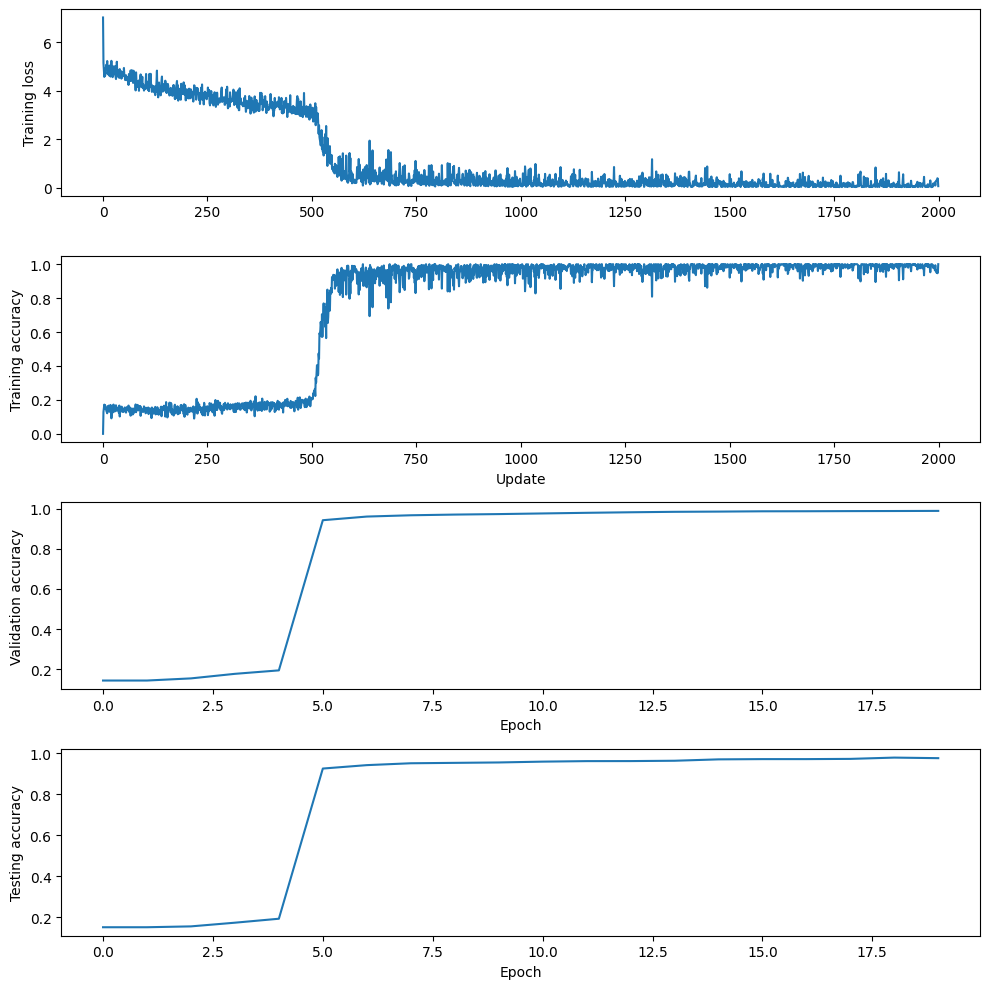

Average training accuracy: 75.63%
Average validation accuracy: 77.36%
Average testing accuracy: 76.14%


In [19]:
# exponential moving averages
ema_decay = 0.
metrics = {"loss": losses, "acc": accs, "val_acc": val_accs, "test_acc":test_accs}
emas = {}
for name, metric in metrics.items():
    emas[name] = [metric[0]]
    for i in range(1, len(metric)):
        emas[name].append(ema_decay*emas[name][-1] + (1 - ema_decay)*metric[i])

fig = pt.figure(figsize=(10,10)) 

pt.subplot(4,1,1)
pt.plot(emas['loss'])
pt.ylabel("Training loss")
pt.subplot(4,1,2)
pt.plot(emas['acc'])
pt.ylabel("Training accuracy")
pt.xlabel("Update")
pt.subplot(4,1,3)
pt.plot(val_accs, label="Unbalanced")
pt.ylabel("Validation accuracy")
pt.xlabel("Epoch")
pt.subplot(4,1,4)
pt.plot(test_accs, label="Unbalanced")
pt.ylabel("Testing accuracy")
pt.xlabel("Epoch")

pt.tight_layout()
pt.savefig("wxexp2.png")
pt.show()

average_acc = sum(emas['acc']) / len(emas['acc'])
print(f"Average training accuracy: {average_acc:.2%}")
average_val_acc = sum(emas['val_acc']) / len(emas['val_acc'])
print(f"Average validation accuracy: {average_val_acc:.2%}")
average_test_acc = sum(emas['test_acc']) / len(emas['test_acc'])
print(f"Average testing accuracy: {average_test_acc:.2%}")

In [20]:
"""
sanity-check high training accuracy
"""

# eval mode (no dropout noise)
model.eval()

for batch in get_batches(train, batch_size, max_len):

    # preprocess batch
    inps, outs, pads, prfs = process_batch(batch, device, max_len)

    # send example through model
    with tr.no_grad():
          logits =  model(inps, pads, outs, prfs) # predictions shifted by one
          targets = model.tgt_embedder.get_index(outs)

    probs = tr.softmax(logits, dim=2)
    top_probs, top_idx = tr.max(probs, dim=2)
    preds = model.tgt_embedder.get_tokens(top_idx)

    correct = []
    for n in range(len(inps)):
        print(n, " ".join(inps[n]))
        print("t, correct, prob of prediction vs target, prediction vs target")
        for t in range(len(inps[n])):
            if not prfs[n,t]: continue

            # accuracy of one-step-ahead prediction
            correct.append(preds[n][t] == outs[n][t])
            print(f"{t}: [p={top_probs[n,t]:3.3f} vs {probs[n,t,targets[n,t]]:3.3f}] {str(correct[-1])[0]}: {preds[n][t]} vs {outs[n][t]}")
        
        break
    break


0 |- ( J |`t A ) = ( TopOpen ` H ) |- H = ( K |`s A ) |- J = ( TopOpen ` K ) $= |- ps |- ( ph -> ps ) |- ( -. ph -> ps ) $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $.
t, correct, prob of prediction vs target, prediction vs target
28: [p=0.989 vs 0.989] T: |- vs |-
29: [p=0.986 vs 0.986] T: ps vs ps
30: [p=0.989 vs 0.989] T: |- vs |-
31: [p=0.992 vs 0.992] T: ( vs (
32: [p=0.981 vs 0.981] T: ph vs ph
33: [p=0.988 vs 0.988] T: -> vs ->
34: [p=0.985 vs 0.985] T: ps vs ps
35: [p=0.988 vs 0.988] T: ) vs )
36: [p=0.989 vs 0.989] T: |- vs |-
37: [p=0.992 vs 0.992] T: ( vs (
38: [p=0.933 vs 0.933] T: -. vs -.
39: [p=0.980 vs 0.980] T: ph vs ph
40: [p=0.988 vs 0.988] T: -> vs ->
41: [p=0.985 vs 0.985] T: ps vs ps
42: [p=0.988 vs 0.988] T: ) vs )
43: [p=0.983 vs 0.983] T: $. vs $.


In [21]:
"""
Training loop
"""

device = tr.device('cpu')
device = tr.device("cuda:0" if tr.cuda.is_available() else "cpu")

max_len = 128
d_model = 256
nhead = 16
nlayers = 10
ff_dim = 4096
denom_base = 500

# batch for GPU speedup
batch_size =10

# noam schedule
use_noam = True
base_lr = 0.0005
warmup = 500
# init model (includes embedding and positional encoding)
model = EncoderDecoderAttentionTransformerPlus(vocab, max_len, denom_base, d_model, nhead, nlayers, ff_dim, device).to(device)

opt = tr.optim.Adam(model.parameters(), lr=base_lr)

# vanilla cross-entropy
loss_fn = tr.nn.CrossEntropyLoss(label_smoothing=0.0)

num_epochs = 20
max_examples = 1000
losses, accs = [], []
test_accs = []
val_accs = []
total_updates = 0
for epoch in range(num_epochs):

    # turn on training mode
    model.train()

    # use random data order every epoch
    random.shuffle(train)

    # train on all the training data
    num_examples = 0
    for batch in get_batches(train, batch_size, max_len):
        if num_examples == max_examples: break
        num_examples += len(batch)

        # preprocess batch
        inps, outs, pads, prfs = process_batch(batch, device, max_len)

        # reset gradient in preparation for forward/backward passes
        opt.zero_grad()

        
        # send example through model
        logits =  model(inps, pads, outs, prfs) # prediction logits shifted by one
        targets = model.tgt_embedder.get_index(outs)

        probs = tr.softmax(logits, dim=2)
        top_probs, top_idx = tr.max(probs, dim=2)
        preds_prt = model.tgt_embedder.get_tokens(top_idx)

        # reshape for cross-entropy
        N, L, V = logits.shape # batch size, max len, vocab size
        logits = logits.reshape((N*L, V))
        targets = targets.reshape((N*L,)) # index of correct token

        # only keep proof positions for loss
        prfs = prfs.flatten()
        logits, targets = logits[prfs], targets[prfs]

        # grad descent on cross-entropy
        loss = loss_fn(logits, targets)
        loss.backward()
        opt.step()

        # Noam ramp-up
        if use_noam:
            upd = total_updates + 1
            lr = base_lr * min(upd ** (-0.5), upd * warmup ** (-1.5))
            for p in opt.param_groups: p['lr'] = lr

        # accuracy of one-step-ahead prediction
        preds = logits.detach().argmax(dim=1)
        acc = (preds == targets).to(float).mean()

        # log results
        losses.append(loss.item())
        accs.append(acc.item())
        
        if num_examples % (batch_size * (100 // batch_size)) == 0:

            for n in range(len(inps)):
              print("inps: ", n, " ".join(inps[n]))
              print("outs: ", n, " ".join(outs[n]))
              print("pred: ", n, " ".join(preds_prt[n]))

            print(f"{epoch}|{num_examples}: loss={losses[-1]}, acc={accs[-1]}")# [{time_elapsed}s]")
        
        total_updates += 1

    # turn on evaluation mode
    model.eval()


    # validation 
    val_acc = []
    for batch in get_batches(val, batch_size, max_len):

        # preprocess batch
        inps, outs, pads, prfs = process_batch(batch, device, max_len)

        # send example through model
        with tr.no_grad():
            logits =  model(inps, pads, outs, prfs) # predictions shifted by one
            targets = model.src_embedder.get_index(outs)
            
            # reshape for cross-entropy
            N, L, V = logits.shape # batch size, max len, vocab size
            logits = logits.reshape((N*L, V))
            targets = targets.reshape((N*L,)) # index of correct token

            # only keep proof positions for loss
            prfs = prfs.flatten()
            logits, targets = logits[prfs], targets[prfs]

            # accuracy of one-step-ahead prediction
            preds = logits.detach().argmax(dim=1)
            acc = (preds == targets).to(float).mean()

            val_acc.append(acc.item())

    val_accs.append(np.mean(val_acc))
    print(f"\n **** validation acc = {val_accs[-1]} ****\n")


    # test on all the testing data
    test_acc = []
    for batch in get_batches(test, batch_size, max_len):

        # preprocess batch
        inps, outs, pads, prfs = process_batch(batch, device, max_len)

        # send example through model
        with tr.no_grad():
            logits =  model(inps, pads, outs, prfs) # predictions shifted by one
            targets = model.tgt_embedder.get_index(outs)
            
            # reshape for cross-entropy
            N, L, V = logits.shape # batch size, max len, vocab size
            logits = logits.reshape((N*L, V))
            targets = targets.reshape((N*L,)) # index of correct token

            # only keep proof positions for loss
            prfs = prfs.flatten()
            logits, targets = logits[prfs], targets[prfs]

            # accuracy of one-step-ahead prediction
            preds = logits.detach().argmax(dim=1)
            acc = (preds == targets).to(float).mean()

            test_acc.append(acc.item())

    test_accs.append(np.mean(test_acc))
    print(f"\n **** test acc = {test_accs[-1]} ****\n")

Streaming output truncated to the last 5000 lines.
outs:  8 ( B e. V -> ( B e. ( A /. R ) <-> E. x e. A B = [ x ] R ) ) $= |- ( A e. V -> ( A e. B <-> ps ) ) $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $.
pred:  8 |- |- |- |- |- |- |- |- |- |- |- ( |- |- |- ( |- |- ( |- ( ) |- |- ) ) |- ( ) ) |- ( ) |- |- ( ( ( |- ) |- ) ( ) ) ) ( ( ) ( |- |- ( ) ) ) ) ( ) ) ) ) ) ) ) |- ( ) ) ( ) ) (
inps:  9 |- ( N e. NN -> ( M ` N ) : Prime --> NN0 ) |- M = ( n e. NN |-> ( p e. Prime |-> ( p pCnt n ) ) ) $= |- ( ph -> ps ) |- ( ph -> ch ) |- ( ph -> ( ps <-> ch ) ) $. $. $. $. $. $. $. $. $. $. $. $. $. $.
outs:  9 ( N e. NN -> ( M ` N ) : Prime --> NN0 ) |- M = ( n e. NN |-> ( p e. Prime |-> ( p pCnt n ) ) ) $= |- ( ph -> ps ) |- ( ph -> ch ) |- ( ph -> ( ps <-> ch ) ) $. $. $. $. $. $. $. $. $. $. $. $. $. $. $.
pred:  9 |- |- |- |- ( |- ( |- ( ( ( ( ( |- ( ( ( ( ( ( ) ( ( ( ( ( ) ) ( ( ) ( ) ( ( ( ) ( ) ( ( ( ( ( ( ( ( ( ) ) ) ) ) ( ) ( ) ) ) ) ( )

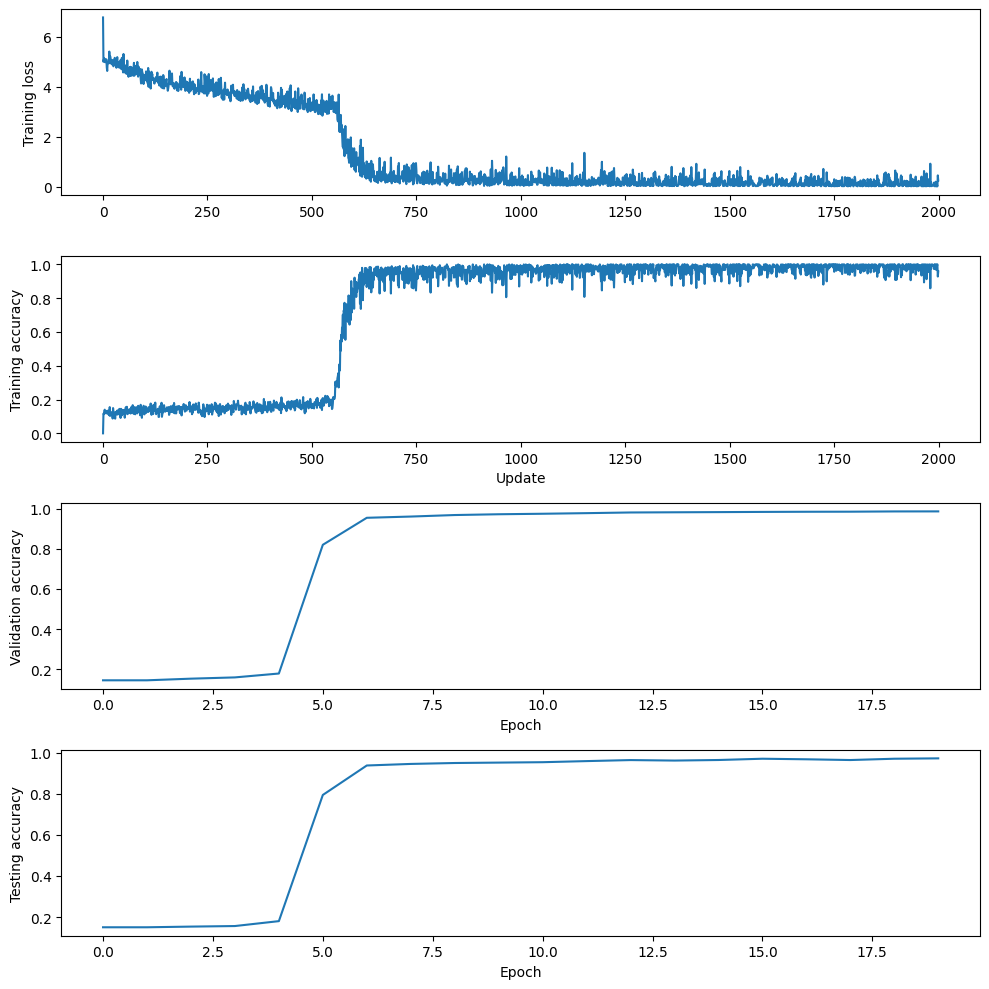

Average training accuracy: 73.17%
Average validation accuracy: 76.40%
Average testing accuracy: 75.13%


In [22]:
# exponential moving averages
ema_decay = 0.
metrics = {"loss": losses, "acc": accs, "val_acc": val_accs, "test_acc":test_accs}
emas = {}
for name, metric in metrics.items():
    emas[name] = [metric[0]]
    for i in range(1, len(metric)):
        emas[name].append(ema_decay*emas[name][-1] + (1 - ema_decay)*metric[i])

fig = pt.figure(figsize=(10,10)) 

pt.subplot(4,1,1)
pt.plot(emas['loss'])
pt.ylabel("Training loss")
pt.subplot(4,1,2)
pt.plot(emas['acc'])
pt.ylabel("Training accuracy")
pt.xlabel("Update")
pt.subplot(4,1,3)
pt.plot(val_accs, label="Unbalanced")
pt.ylabel("Validation accuracy")
pt.xlabel("Epoch")
pt.subplot(4,1,4)
pt.plot(test_accs, label="Unbalanced")
pt.ylabel("Testing accuracy")
pt.xlabel("Epoch")

pt.tight_layout()
pt.savefig("wxexp3.png")
pt.show()

average_acc = sum(emas['acc']) / len(emas['acc'])
print(f"Average training accuracy: {average_acc:.2%}")
average_val_acc = sum(emas['val_acc']) / len(emas['val_acc'])
print(f"Average validation accuracy: {average_val_acc:.2%}")
average_test_acc = sum(emas['test_acc']) / len(emas['test_acc'])
print(f"Average testing accuracy: {average_test_acc:.2%}")

In [23]:
"""
sanity-check high training accuracy
"""

# eval mode (no dropout noise)
model.eval()

for batch in get_batches(train, batch_size, max_len):

    # preprocess batch
    inps, outs, pads, prfs = process_batch(batch, device, max_len)

    # send example through model
    with tr.no_grad():
          logits =  model(inps, pads, outs, prfs) # predictions shifted by one
          targets = model.tgt_embedder.get_index(outs)

    probs = tr.softmax(logits, dim=2)
    top_probs, top_idx = tr.max(probs, dim=2)
    preds = model.tgt_embedder.get_tokens(top_idx)

    correct = []
    for n in range(len(inps)):
        print(n, " ".join(inps[n]))
        print("t, correct, prob of prediction vs target, prediction vs target")
        for t in range(len(inps[n])):
            if not prfs[n,t]: continue

            # accuracy of one-step-ahead prediction
            correct.append(preds[n][t] == outs[n][t])
            print(f"{t}: [p={top_probs[n,t]:3.3f} vs {probs[n,t,targets[n,t]]:3.3f}] {str(correct[-1])[0]}: {preds[n][t]} vs {outs[n][t]}")
        
        break
    break


0 |- ( F Fn A -> |^|_ x e. A ( F ` x ) = |^| ran F ) $= |- ( F ` A ) e. _V $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $. $.
t, correct, prob of prediction vs target, prediction vs target
20: [p=0.989 vs 0.989] T: |- vs |-
21: [p=0.990 vs 0.990] T: ( vs (
22: [p=0.914 vs 0.914] T: F vs F
23: [p=0.832 vs 0.832] T: ` vs `
24: [p=0.979 vs 0.979] T: A vs A
25: [p=0.988 vs 0.988] T: ) vs )
26: [p=0.962 vs 0.962] T: e. vs e.
27: [p=0.325 vs 0.325] T: _V vs _V
28: [p=0.981 vs 0.981] T: $. vs $.
